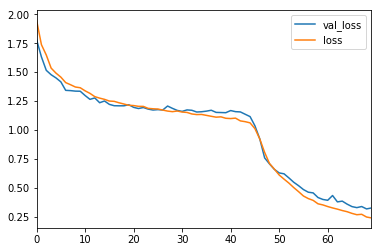

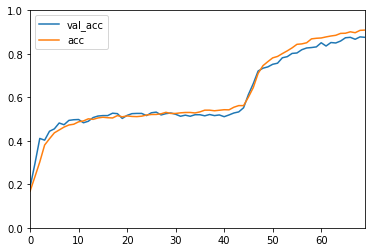

10000/10000 [==============================] - 1s 76us/step
John travelled to the hallway . Mary journeyed to the bathroom . Where is John ? | Prediction: hallway | Ground Truth: hallway
John travelled to the hallway . Mary journeyed to the bathroom . Daniel went back to the bathroom . John moved to the bedroom . Where is Mary ? | Prediction: bathroom | Ground Truth: bathroom
John travelled to the hallway . Mary journeyed to the bathroom . Daniel went back to the bathroom . John moved to the bedroom . John went to the hallway . Sandra journeyed to the kitchen . Where is Sandra ? | Prediction: kitchen | Ground Truth: kitchen
John travelled to the hallway . Mary journeyed to the bathroom . Daniel went back to the bathroom . John moved to the bedroom . John went to the hallway . Sandra journeyed to the kitchen . Sandra travelled to the hallway . John went to the garden . Where is Sandra ? | Prediction: hallway | Ground Truth: hallway
John travelled to the hallway . Mary journeyed to the b

In [ ]:
import keras
from keras.models import Sequential, Model
from keras.layers.embeddings import Embedding
from keras.layers import Input, Activation, Dense, Permute, Dropout, merge
from keras.layers import LSTM, GRU
from keras.utils.data_utils import get_file
from keras.preprocessing.sequence import pad_sequences
from keras import backend as K
from functools import reduce
import tarfile
import numpy as np
import re
import IPython
import matplotlib.pyplot as plt
import pandas as pd
import os
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Activation, Dense, Permute, Dropout, add, dot, concatenate
from keras.layers import LSTM
from nltk.tokenize import word_tokenize
#from Text_Preprocessing import *
import numpy as np
import pickle
import random



def tokenize(sent):
    return [ x.strip() for x in re.split('(\W+)?', sent) if x.strip()]

def parse_stories(lines, only_supporting=False):
    '''Parse stories provided in the bAbi tasks format
    If only_supporting is true, only the sentences
    that support the answer are kept.
    '''
    data = []
    story = []
    for line in lines:
        line = line.decode('utf-8').strip()
        nid, line = line.split(' ', 1)
        nid = int(nid)
        if nid == 1:
            story = []
        if '\t' in line:
            q, a, supporting = line.split('\t')
            q = tokenize(q)
            substory = None
            if only_supporting:
                # Only select the related substory
                supporting = map(int, supporting.split())
                substory = [story[i - 1] for i in supporting]
            else:
                # Provide all the substories
                substory = [x for x in story if x]
            data.append((substory, q, a))
            story.append('')
        else:
            sent = tokenize(line)
            story.append(sent)
    return data


def get_stories(f, only_supporting=False, max_length=None):
    data = parse_stories(f.readlines(), only_supporting=only_supporting)
    flatten = lambda data: reduce(lambda x, y: x + y, data)
    data = [(flatten(story), q, answer) for story, q, answer in data if not max_length or len(flatten(story)) < max_length]
    return data





def vectorize_stories(data, word_idx, story_maxlen, query_maxlen):
    X = []
    Xq = []
    Y = []
    for story, query, answer in data:
        x = [word_idx[w] for w in story]
        xq = [word_idx[w] for w in query]
        # let's not forget that index 0 is reserved
        y = np.zeros(len(word_idx) + 1)
        y[word_idx[answer]] = 1
        X.append(x)
        Xq.append(xq)
        Y.append(y)
    return (pad_sequences(X, maxlen=story_maxlen),
            pad_sequences(Xq, maxlen=query_maxlen), np.array(Y))  
class TrainingVisualizer(keras.callbacks.History):
    def on_epoch_end(self, epoch, logs={}):
        super().on_epoch_end(epoch, logs)
        IPython.display.clear_output(wait=True)
        pd.DataFrame({key: value for key, value in self.history.items() if key.endswith('loss')}).plot()
        axes = pd.DataFrame({key: value for key, value in self.history.items() if key.endswith('acc')}).plot()
        axes.set_ylim([0, 1])
        plt.show()    


try:
    path = get_file('/content/gdrive/My Drive/tasks_1-20_v1-2.tar.gz',origin='content/gdrive/My Drive/tasks_1-20_v1-2.tar.gz')
   # path = get_file('babi-tasks-v1-2.tar.gz', path1='content/gdrive/My Drive/tasks_1-20_v1-2.tar.gz')
except:
   # print('Error geting  dataset, please download it manually:\n'
        #  '$ wget http://www.thespermwhale.com/jaseweston/babi/tasks_1-20_v1-2.tar.gz\n'
         # '$ mv tasks_1-20_v1-2.tar.gz ~/.keras/datasets/babi-tasks-v1-2.tar.gz')
    raise
tar = tarfile.open(path)
challenges = {
    # QA1 with 10,000 samples
    'single_supporting_fact_10k': 'tasks_1-20_v1-2/en-10k/qa1_single-supporting-fact_{}.txt',
    # QA2 with 10,000 samples
    'two_supporting_facts_10k': 'tasks_1-20_v1-2/en-10k/qa2_two-supporting-facts_{}.txt',
}
challenge_type = 'single_supporting_fact_10k'
challenge = challenges[challenge_type]

#print('Extracting stories for the challenge:', challenge_type)
train_stories = get_stories(tar.extractfile(challenge.format('train')))
test_stories = get_stories(tar.extractfile(challenge.format('test')))
len(train_stories), len(test_stories)
vocab = set()
for story, q, answer in train_stories + test_stories:
    vocab |= set(story + q + [answer])
vocab = sorted(vocab)

# Reserve 0 for masking via pad_sequences
vocab_size = len(vocab) + 1
story_maxlen = max(map(len, (x for x, _, _ in train_stories + test_stories)))
query_maxlen = max(map(len, (x for _, x, _ in train_stories + test_stories)))
story_maxlen, query_maxlen
#print('-')
#print('Vocab size:', vocab_size, 'unique words')
#print('Story max length:', story_maxlen, 'words')
#print('Query max length:', query_maxlen, 'words')
#print('Number of training stories:', len(train_stories))
#print('Number of test stories:', len(test_stories))
#print('-')
#print('Here\'s what a "story" tuple looks like (input, query, answer):')
#print(train_stories[0])
#print('-')
#print('Vectorizing the word sequences...')

word_idx = dict((c, i + 1) for i, c in enumerate(vocab))
idx_word = dict((i+1, c) for i,c in enumerate(vocab))
inputs_train, queries_train, answers_train = vectorize_stories(train_stories,
                                                               word_idx,
                                                               story_maxlen,
                                                               query_maxlen)
inputs_test, queries_test, answers_test = vectorize_stories(test_stories,
                                                            word_idx,
                                                            story_maxlen,
                                                            query_maxlen)
inputs_train.shape, queries_train.shape, answers_train.shape
#print('-')
#print('inputs: integer tensor of shape (samples, max_length)')
#print('inputs_train shape:', inputs_train.shape)
#print('inputs_test shape:', inputs_test.shape)
#print('-')
#print('queries: integer tensor of shape (samples, max_length)')
#print('queries_train shape:', queries_train.shape)
#print('queries_test shape:', queries_test.shape)
#print('-')
#print('answers: binary (1 or 0) tensor of shape (samples, vocab_size)')
#print('answers_train shape:', answers_train.shape)
#print('answers_test shape:', answers_test.shape)
#print('-')
#print('Compiling...')
#train_epochs = 70
batch_size = 32
lstm_size = 64
input_sequence = Input((story_maxlen,))
question = Input((query_maxlen,))

#print('Input sequence:', input_sequence)
#print('Question:', question)

# encoders
# embed the input sequence into a sequence of vectors
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size,
                              output_dim=64))
input_encoder_m.add(Dropout(0.3))
# output: (samples, story_maxlen, embedding_dim)

# embed the input into a sequence of vectors of size query_maxlen
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size,
                              output_dim=query_maxlen))
input_encoder_c.add(Dropout(0.3))
# output: (samples, story_maxlen, query_maxlen)

# embed the question into a sequence of vectors
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size,
                               output_dim=64,
                               input_length=query_maxlen))
question_encoder.add(Dropout(0.3))
# output: (samples, query_maxlen, embedding_dim)

# encode input sequence and questions (which are indices)
# to sequences of dense vectors
input_encoded_m = input_encoder_m(input_sequence)
#print('Input encoded m', input_encoded_m)
input_encoded_c = input_encoder_c(input_sequence)
#print('Input encoded c', input_encoded_c)
question_encoded = question_encoder(question)
#print('Question encoded', question_encoded)


match = dot([input_encoded_m, question_encoded], axes=(2, 2))
match = Activation('softmax')(match)
# add the match matrix with the second input vector sequence
response = add([match, input_encoded_c])  # (samples, story_maxlen, query_maxlen)




response = Permute((2, 1))(response)  # (samples, query_maxlen, story_maxlen)


answer = concatenate([response, question_encoded])

        # we choose to use a RNN instead.
answer = LSTM(32)(answer)  # (samples, 32)

answer = Dropout(0.3)(answer)
answer = Dense(vocab_size)(answer)  # (samples, vocab_size)
        # we output a probability distribution over the vocabulary
answer = Activation('softmax')(answer)
model = Model([input_sequence, question], answer)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])

#train_epochs=70
model.fit([inputs_train, queries_train], answers_train, batch_size, train_epochs,callbacks=[TrainingVisualizer()],
        validation_data=([inputs_test, queries_test], answers_test))

model.save('/content/gdrive/My Drive/Colab Notebooks/model.hu')
#print('Evaluation')
loss, acc = model.evaluate([inputs_train, queries_train], answers_train,
                           batch_size=batch_size)
#print('Test loss / test accuracy = {:.4f} / {:.4f}'.format(loss, acc))
for i in range(0,10):
        current_inp = test_stories[i]
        current_story, current_query, current_answer = vectorize_stories([current_inp], word_idx, story_maxlen, query_maxlen)
        current_prediction = model.predict([current_story, current_query])
        current_prediction = idx_word[np.argmax(current_prediction)]
        print(' '.join(current_inp[0]), ' '.join(current_inp[1]), '| Prediction:', current_prediction, '| Ground Truth:', current_inp[2])
        #print("-----------------------------------------------------------------------------------------")
print('-------------------------------------------------------------------------------------------')
print('Custom User Queries (Make sure there are spaces before each word)')
while 1:
    print('-------------------------------------------------------------------------------------------')
    print('Please input a story')
    user_story_inp = input().split(' ')
    print('Please input a query')
    user_query_inp = input().split(' ')
    print('Please enter the options')
    user_story_inp1 = input().split(' ')
    user_story, user_query, user_ans = vectorize_stories([[user_story_inp, user_query_inp, '.']], word_idx, story_maxlen, query_maxlen)
    user_prediction = model.predict([user_story, user_query])
    user_prediction = idx_word[np.argmax(user_prediction)]
    print('Result')
    #print(user_prediction)
    print(' '.join(user_story_inp), ' '.join(user_query_inp), '| Prediction:', user_prediction)

# New Section